In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc

%load_ext nb_black
use_cuda = True


In [2]:
import sys
data_path = "../../../TabulaSapiensData/"
ts_path = "../"
sys.path.append(ts_path)


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
adata = read_h5ad(data_path + "decontX/Pilot1_Pilot2.decontX.h5ad")

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


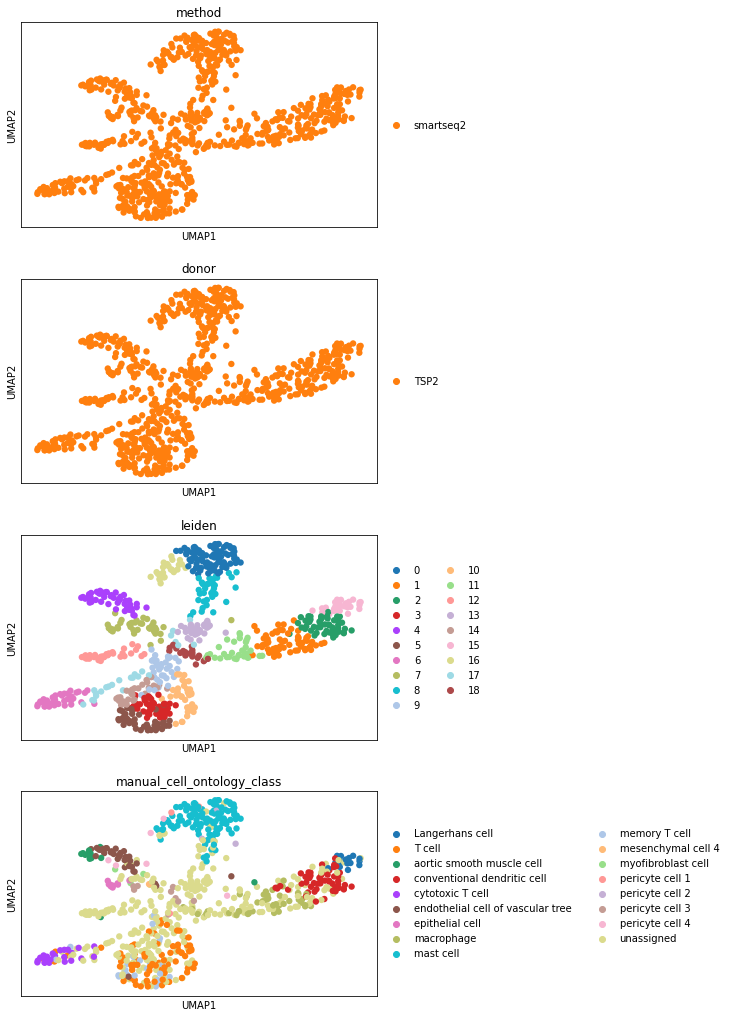

In [5]:
organ = "Skin"
organ_adata = adata[adata.obs["tissue"] == organ]
sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [6]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

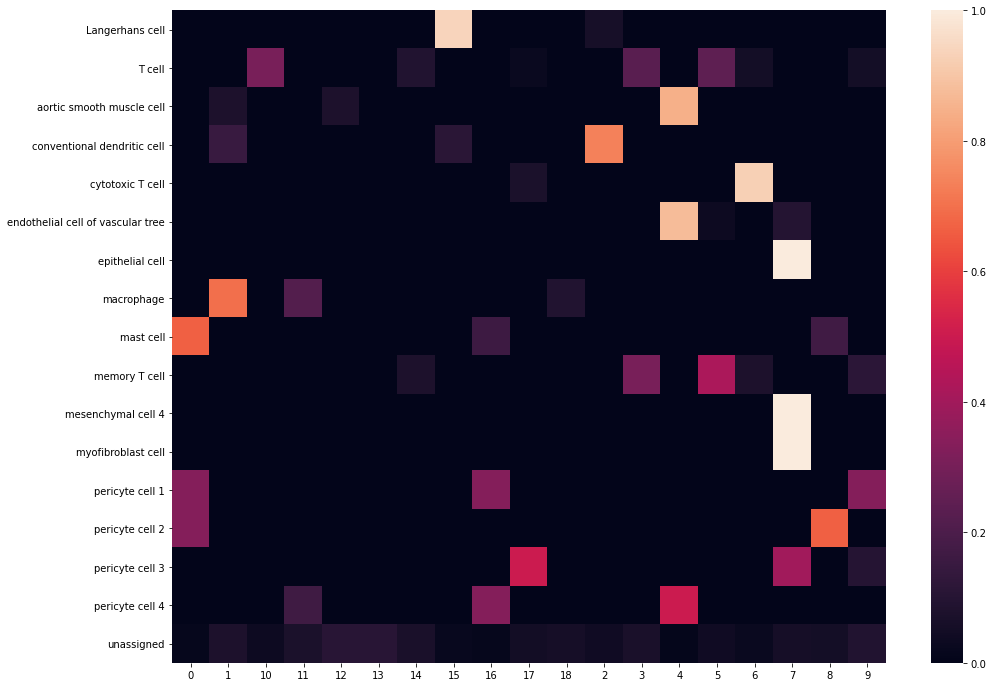

In [7]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.sum(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [8]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [9]:
cluster_composition["0"]

['mast cell: 0.93',
 'pericyte cell 1: 0.01',
 'pericyte cell 2: 0.01',
 'unassigned: 0.05']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [10]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [11]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

<ipython-input-1-963029a66ab7>:5: RuntimeWarning: invalid value encountered in long_scalars
  return (np.max(x) / np.sum(x), names[np.argmax(x)])


In [12]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


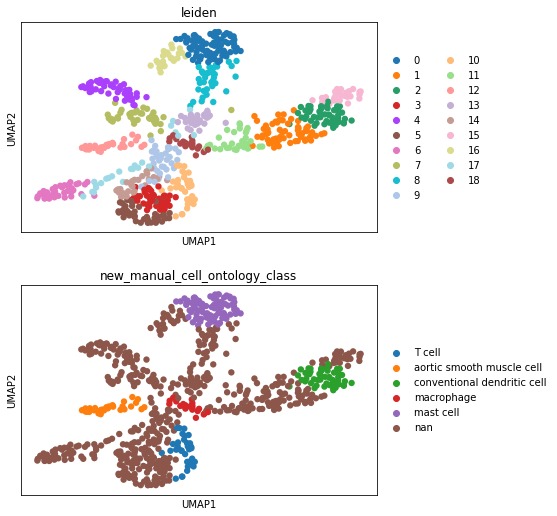

In [13]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [14]:
organ_adata.obs.groupby(["leiden"]).agg(
    {"new_manual_cell_ontology_class": set, "Propagated.Annotation": set}
)

new_manual_cell_ontology_class  \
leiden                                  
0                         {mast cell}   
1                               {nan}   
2       {conventional dendritic cell}   
3                               {nan}   
4                               {nan}   
5                               {nan}   
6                               {nan}   
7                               {nan}   
8                               {nan}   
9                               {nan}   
10                           {T cell}   
11                              {nan}   
12        {aortic smooth muscle cell}   
13                              {nan}   
14                              {nan}   
15                              {nan}   
16                              {nan}   
17                              {nan}   
18                       {macrophage}   

                                    Propagated.Annotation  
leiden                                                     
0                  {mast cell, aortic smooth muscle cell}  
1       {macrophage, conventional dendritic cell, Lang...  
2       {macrophage, conventional dendritic cell, Lang...  
3                      {T cell, mast cell, memory T cell}  
4       {T cell, aortic smooth muscle cell, endothelia...  
5       {T cell, endothelial cell of vascular tree, me...  
6               {cytotoxic T cell, T cell, memory T cell}  
7       {epithelial cell, pericyte cell 3, myofibrobla...  
8       {mast cell, macrophage, T cell, conventional d...  
9               {cytotoxic T cell, T cell, memory T cell}  
10                                       {B cell, T cell}  
11      {macrophage, conventional dendritic cell, T cell}  
12      {epithelial cell, cytotoxic T cell, T cell, ao...  
13      {epithelial cell, B cell, mast cell, macrophag...  
14              {cytotoxic T cell, T cell, memory T cell}  
15         {conventional dendritic cell, Langerhans cell}  
16         {mast cell, aortic smooth muscle cell, T cell}  
17      {macrophage, cytotoxic T cell, T cell, convent...  
18       {macrophage, T cell, mast cell, Langerhans cell}

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


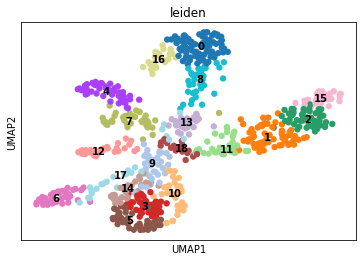

In [15]:
sc.pl.umap(organ_adata, color="leiden", legend_loc="on data")

# Sankey Diagram between cluster and compartment

In [16]:
from utils.colorDict import (
    donor_colors,
    method_colors,
    compartment_colors,
    tissue_colors,
)

In [17]:
from utils.plotting_utils import *
from utils.colorDict import compartment_colors

import plotly
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.io as pio

pio.renderers.default = "notebook"

init_notebook_mode(connected=True)

In [18]:
df = pd.DataFrame(columns=["celltype", "compartment", "count"])
for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
    for c in np.unique(organ_adata.obs["compartment_pred_svm"]):
        x = np.sum(
            (organ_adata.obs["compartment_pred_svm"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )
        df = df.append(
            pd.DataFrame([t, c, x], index=["celltype", "compartment", "count"]).T,
            ignore_index=True,
        )


fig = genSankey(
    df,
    cat_cols_color=[compartment_colors(), "#00A1E0"],
    cat_cols=["compartment", "celltype"],
    value_cols="count",
    title="celltype-compartment",
)
iplot(fig, validate=False)
plotly.offline.plot(
    fig, validate=False, filename="figures/celltype_sankey_%s" % organ + ".html"
)  # , output_type='div')

'figures/celltype_sankey_Skin.html'

# visualize compartment markers

In [19]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [20]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



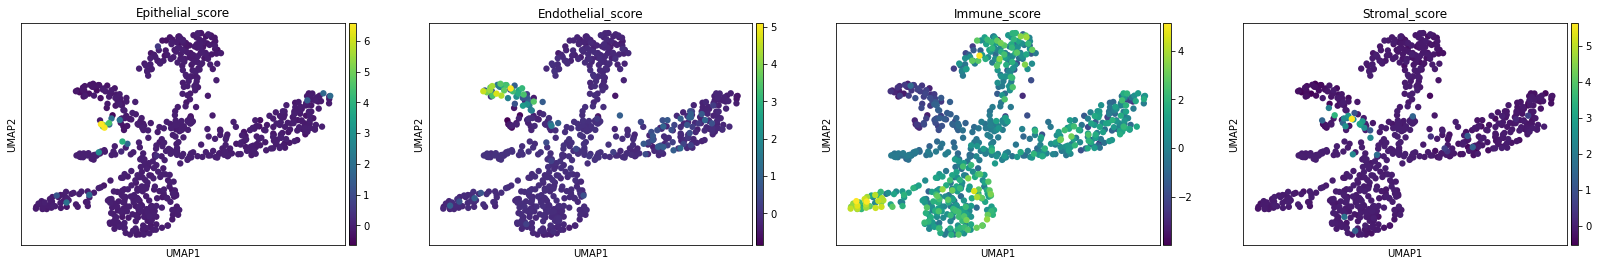

In [21]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# Find markers for each cluster

In [22]:
sc.tl.rank_genes_groups(organ_adata, groupby="leiden", method="wilcoxon")

In [23]:
def FormatDE(res):
    groups = res['scores'].dtype.names
    df_res = {}
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        df_res[group] = df
    return df_res


In [24]:
DE = FormatDE(organ_adata.uns["rank_genes_groups"])

### top positive marker genes

In [25]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])
organ_cluster_genes.iloc[:20]


0         1         2         3         4         5          6  \
0    TPSAB1      TLR2     CCL22     CXCR4    EEF1A1    CNOT6L       CD96   
1     TPSB2      PID1      CD74     SARAF    TM4SF1      RORA      KLRK1   
2      CPA3     CXCL8     IL4I1    IFITM1  EEF1A1P5      IL7R       GNLY   
3       KIT  C15orf48      CCR7    CNOT6L  EEF1A1P6     CXCR4       GZMB   
4    IL1RL1      ETS2   HLA-DRA      CD69  SERPINE1     TXNIP       AREG   
5       HDC     IL1R2  HLA-DRB1   ARHGDIB      CAV1  LEPROTL1  LINC01871   
6     MELTF      EREG  HLA-DPA1   TSC22D3  RPL18AP3    RNF19A     SEPT11   
7      RGS2     ACSL1     DUSP5      IL7R     SPARC       FYN       XCL1   
8     ASAH1   HLA-DRA   RNF144B   ZFP36L2      CD59     PTPRC      MPZL3   
9   PHACTR4   ATP13A3  HLA-DPB1      RORA     HSPB1      CD53       XCL2   
10  LAPTM4A     TIMP1     NFKB1    RPL13A   ADAMTS9     PRDM1       PGK1   
11     HPGD     CXCL3  C15orf48      CCR4     HLA-B    CRYBG1       JAML   
12      CPM    RNASE1      CD83     PTPRC      DSTN     TRBC1       PRF1   
13     MPP1      SOD2      KYNU     TXNIP    RPL3P4      CD96       SMC4   
14     PRKX     NAMPT  HLA-DQA1      EML4      ESAM     RPS16      SYTL3   
15    GATA2     CEBPB       REL    RNF19A      RPS6     TRBC2      PTPRC   
16     CAPG  HLA-DRB1     MTSS1     PRDM1     HLA-E     RBMS1       CD53   
17     CTSG       FTL    GPR183  LEPROTL1   NPM1P27   ZFP36L2      KLRC1   
18   RNF130    FCER1G   RAPGEF1     NR3C1     RPL23     SARAF       AHI1   
19    HPGDS     MMP19     CIITA   PPP2R5C     IFI27    FKBP11       AGO2   

           7           8           9       10      11          12          13  \
0       MT2A        LMNA       CXCR4    TRBC1  RNASE1        MT1X   RF00100-4   
1     IFITM3     PHACTR4       RPS27  ARHGDIB    CTSL       VAMP8      RNU1-1   
2     RPL7P9        RGS2  AC002075.2   CLEC2D   CD163     TSC22D1     RNU6-6P   
3       RPL7       TPSB2    RPS27P21    PTPRC    CCL3     S100A16      RNU1-4   
4       MT1X        SGK1      RPS7P1     CD3D    C1QB     PRELID1      RNU1-2   
5       SOD2      TPSAB1        RORA      CD2   CXCL1      SPTSSA     SNORD3A   
6    MT-RNR1      TUBB4B  AC099336.2      CD7    C1QC        IDH2       PRMT9   
7     RPL7P1         FUS       MRPL1     TRAC  MARCKS        LDHA   HIST1H2BN   
8      RPL23  AC129492.1       RPS17    IKZF3   ANPEP      MT1XP1  AC245014.3   
9    RPL39P3       PLIN2  AC090602.1     FYB1   CXCL2       HMGA1  AL512646.1   
10      YBX3       CPEB4    SCARNA21      FYN    TLR2        MT2A     RN7SKP9   
11   HNRNPH1      ADGRE2      RNF19A    CXCR4   CEBPB  AC016734.1    HIST1H4C   
12     H3F3B        CKS2       TRBC2     CD3E    MAFB        SOD2  AC109326.1   
13  HSP90AA1       KDM6B        RPS7    PRDM1   TGFBI        PDK3       CSKMT   
14  HSP90AB1      AKAP13        FYB1     IL32    EMP1        SOX4      RNU1-3   
15   ZFP36L1         HDC  BX679664.1     CD3G   CXCL3        KRT7   HIST1H2BG   
16   RPS23P8      SQSTM1       TRAT1    TIGIT    PID1    SERPINB1   RN7SKP255   
17      NPM1    RASGEF1B       TRBC1  RASGRP1  FCGR2A      AKR1C1   RN7SKP203   
18      CD59      DNAJB9      ATF7IP    SARAF   MARCO       KRT18        ATF5   
19     HSPE1    CDC42EP3      SAMHD1    PDCD4   MMP19     TPD52L1    SNORD12C   

            14        15       16       17           18  
0        RPS27  TMSB4XP4      KIT    CXCR4       ADGRG3  
1        RPS19  TMSB4XP8   TPSAB1  SLC38A1        GLOD4  
2   AC005912.1  HLA-DQB1    TPSB2      FOS        PGGHG  
3        CXCR4      CST7    MELTF     CLK1    RF00601-2  
4        RPL21  HLA-DPB1   IL1RL1     CCNH   AC084824.2  
5        RPS29  HLA-DQA1  PHACTR4   TUBA4A   AP003469.3  
6   AC002075.2  HLA-DPA1      HDC    NR4A1   CNOT10-AS1  
7      RPL41P1    TMSB4X    ASAH1      JMY   AP001889.1  
8       RPL13A  HLA-DRB6     RGS2  ZFP36L2     HMGB3P26  
9   BX679664.1  HLA-DQA2     CAPG    MPZL3    LINC00572  
10      RPL23A      CD74     HPGD      FYN   AC026320.1  
11       PTPRC 

In [26]:
for x in DE.keys():
    print(x)
    display(DE[x].T[:20])

0


wilcoxon_score  log fold change  adjusted pvalue
TPSAB1        13.781761        12.615025     1.130673e-38
TPSB2         13.770391        12.859038     1.130673e-38
CPA3          13.600959        10.616597     7.755528e-38
KIT           13.498078         8.155722     2.362276e-37
IL1RL1        13.249059         8.518619     5.379497e-36
HDC           13.198035         9.618296     8.835767e-36
MELTF         13.154498        10.048015     1.348499e-35
RGS2          12.857505         8.849371     5.743929e-34
ASAH1         12.838648         7.588151     6.514845e-34
PHACTR4       12.453472         7.250800     7.882172e-32
LAPTM4A       12.292081         6.835224     5.346518e-31
HPGD          12.262132         7.775386     7.095977e-31
CPM           11.894980         7.324996     5.691470e-29
MPP1          11.755496         7.416800     2.782479e-28
PRKX          11.739967         6.635059     3.120783e-28
GATA2         11.697817         8.019414     4.811680e-28
CAPG          11.670363         7.403489     6.255764e-28
CTSG          11.658717         9.333656     6.774622e-28
RNF130        11.407479         5.983120     1.188827e-26
HPGDS         11.301271         9.237243     3.806880e-26

1


wilcoxon_score  log fold change  adjusted pvalue
TLR2           11.466897         7.712095     1.138971e-25
PID1           10.960825         7.520720     1.735477e-23
CXCL8          10.716366         9.611289     1.673654e-22
C15orf48       10.393178         8.309464     3.919698e-21
ETS2           10.347839         6.060928     5.039695e-21
IL1R2          10.243072         7.923645     1.247407e-20
EREG           10.198346         8.142640     1.696113e-20
ACSL1          10.124518         6.346300     3.164943e-20
HLA-DRA         9.982989         8.086772     1.183498e-19
ATP13A3         9.942859         4.929694     1.595012e-19
TIMP1           9.817260         7.563496     5.078230e-19
CXCL3           9.682470         7.937332     1.756095e-18
RNASE1          9.602515         8.144942     3.532952e-18
SOD2            9.572188         6.556398     4.401235e-18
NAMPT           9.493765         5.636323     8.745599e-18
CEBPB           9.478142         4.494669     9.524109e-18
HLA-DRB1        9.462213         5.992332     1.044063e-17
FTL             9.328035         3.683822     3.527336e-17
FCER1G          9.310267         6.402699     3.753269e-17
MMP19           9.310267         7.019285     3.753269e-17

2


wilcoxon_score  log fold change  adjusted pvalue
CCL22          11.150795        11.793074     4.177959e-24
CD74           10.905215        10.299953     2.360242e-23
IL4I1          10.896120         8.306105     2.360242e-23
CCR7           10.810218        10.351523     4.532078e-23
HLA-DRA        10.742169        10.202435     7.595433e-23
HLA-DRB1       10.681196         8.333465     1.223077e-22
HLA-DPA1       10.663342         8.807915     1.270498e-22
DUSP5          10.619549         7.884978     1.778815e-22
RNF144B        10.588893         7.420240     2.194780e-22
HLA-DPB1       10.553185         7.843446     2.890751e-22
NFKB1          10.534320         6.862833     3.211926e-22
C15orf48       10.488505         9.113138     4.529568e-22
CD83           10.486147         9.080244     4.529568e-22
KYNU           10.429553         7.587189     7.390129e-22
HLA-DQA1       10.426184         6.418942     7.390129e-22
REL            10.402603         6.099216     8.876551e-22
MTSS1          10.376664         6.968440     1.096533e-21
GPR183         10.312322         7.278111     2.027280e-21
RAPGEF1        10.301205         6.538767     2.156022e-21
CIITA          10.229788         7.200342     4.277428e-21

3


wilcoxon_score  log fold change  adjusted pvalue
CXCR4           8.339791         6.529510     4.381211e-12
SARAF           8.067695         5.029584     2.108670e-11
IFITM1          7.825196         6.444247     9.946393e-11
CNOT6L          7.455743         4.465100     1.315193e-09
CD69            7.171878         5.663992     8.709910e-09
ARHGDIB         6.981446         5.793321     2.866552e-08
TSC22D3         6.911550         4.796879     3.635730e-08
IL7R            6.907270         5.095498     3.635730e-08
ZFP36L2         6.599868         3.624320     2.457852e-07
RORA            6.597728         4.831211     2.457852e-07
RPL13A          6.519273         2.600567     3.780999e-07
CCR4            6.407296         4.410893     7.266661e-07
PTPRC           6.387682         4.150031     7.626774e-07
TXNIP           6.271782         3.948332     1.500923e-06
EML4            6.236478         3.789294     1.756417e-06
RNF19A          6.014307         3.760944     6.256082e-06
PRDM1           6.001825         3.313506     6.381232e-06
LEPROTL1        5.824944         3.968870     1.770178e-05
NR3C1           5.746489         3.618215     2.681983e-05
PPP2R5C         5.737574         3.450577     2.692389e-05

4


wilcoxon_score  log fold change  adjusted pvalue
EEF1A1         10.821114         3.763816     6.205319e-23
TM4SF1         10.812827        13.521809     6.205319e-23
EEF1A1P5       10.807782         3.431473     6.205319e-23
EEF1A1P6       10.718069         3.515888     1.009182e-22
SERPINE1       10.715907        15.329737     1.009182e-22
CAV1           10.626554        11.983049     2.200226e-22
RPL18AP3       10.529995         3.977940     5.284674e-22
SPARC          10.439921        12.982384     1.115506e-21
CD59           10.435597         6.972516     1.115506e-21
HSPB1          10.401730        10.484330     1.433327e-21
ADAMTS9        10.391281        11.566889     1.453979e-21
HLA-B          10.371465         5.301767     1.640313e-21
DSTN           10.330030         8.557955     2.334152e-21
RPL3P4         10.242119         4.264800     5.269302e-21
ESAM           10.237795        13.773645     5.269302e-21
RPS6           10.213655         4.283712     6.337750e-21
HLA-E          10.187354         6.841119     7.820274e-21
NPM1P27        10.126824         4.876365     1.373868e-20
RPL23          10.104126         3.917751     1.559053e-20
IFI27          10.104126        11.282632     1.559053e-20

5


wilcoxon_score  log fold change  adjusted pvalue
CNOT6L          7.657264         4.641683     1.118150e-09
RORA            7.553106         5.847756     1.250980e-09
IL7R            7.261243         5.496872     7.526493e-09
CXCR4           7.093413         5.893143     1.699786e-08
TXNIP           7.079795         4.597008     1.699786e-08
LEPROTL1        7.026796         4.990601     1.824757e-08
RNF19A          7.023116         4.754080     1.824757e-08
FYN             6.832834         4.593683     6.126398e-08
PTPRC           6.677517         4.549708     1.589647e-07
CD53            6.639608         4.801573     1.851568e-07
PRDM1           6.615317         3.916023     1.984221e-07
CRYBG1          6.534346         3.822068     3.134241e-07
TRBC1           6.490180         4.528642     3.882420e-07
CD96            6.454847         5.259301     4.555190e-07
RPS16           6.434973         2.770235     4.846783e-07
TRBC2           6.411786         5.464714     5.291857e-07
RBMS1           6.234754         4.251444     1.507980e-06
ZFP36L2         6.231810         3.523936     1.507980e-06
SARAF           6.221872         3.948554     1.522120e-06
FKBP11          6.138693         4.865000     2.449083e-06

6


wilcoxon_score  log fold change  adjusted pvalue
CD96             8.959555         7.079631     1.640752e-14
KLRK1            8.900209         8.024460     1.640752e-14
GNLY             8.725257        11.800103     5.211500e-14
GZMB             8.595006         9.545897     1.113519e-13
AREG             8.580362         6.898006     1.113519e-13
LINC01871        8.490575         8.205078     2.017456e-13
SEPT11           8.398474         6.733437     3.803990e-13
XCL1             8.112154         8.977244     3.659529e-12
MPZL3            8.014658         5.725859     7.224233e-12
XCL2             7.892886         8.911947     1.738304e-11
PGK1             7.783830         5.184636     3.765624e-11
JAML             7.710226         6.255126     6.161475e-11
PRF1             7.576893         8.396913     1.602755e-10
SMC4             7.471305         5.704609     3.338916e-10
SYTL3            7.274773         4.478591     1.361876e-09
PTPRC            7.237008         5.045848     1.687701e-09
CD53             6.996930         5.188696     9.060151e-09
KLRC1            6.918317         9.115679     1.494774e-08
AHI1             6.714849         4.440653     5.833133e-08
AGO2             6.707141         3.889755     5.842074e-08

7


wilcoxon_score  log fold change  adjusted pvalue
MT2A            7.918968         6.096812     1.409874e-10
IFITM3          7.536654         5.739076     9.462015e-10
RPL7P9          7.283859         2.879605     4.774412e-09
RPL7            7.200764         3.863261     7.049792e-09
MT1X            7.132104         5.967700     9.698457e-09
SOD2            6.990102         5.913178     2.310119e-08
MT-RNR1         6.933145         3.216645     3.028764e-08
RPL7P1          6.887501         2.556869     3.714104e-08
RPL23           6.862534         2.736312     3.982543e-08
RPL39P3         6.839907         3.394763     4.241029e-08
YBX3            6.821181         5.447847     4.429715e-08
HNRNPH1         6.787632         3.192896     5.161968e-08
H3F3B           6.741208         3.555093     6.605031e-08
HSP90AA1        6.716630         4.296123     7.298903e-08
HSP90AB1        6.614030         4.328620     1.295129e-07
ZFP36L1         6.546930         4.231839     1.819765e-07
RPS23P8         6.536787         2.836913     1.850125e-07
NPM1            6.504797         4.701773     2.180945e-07
CD59            6.459544         4.491763     2.810218e-07
HSPE1           6.410779         5.131980     3.705682e-07

8


wilcoxon_score  log fold change  adjusted pvalue
LMNA              6.993945         5.787342     1.573372e-07
PHACTR4           6.817348         4.918822     2.729692e-07
RGS2              6.275706         6.056430     6.829940e-06
TPSB2             6.037478         7.518622     2.303903e-05
SGK1              5.931599         4.480339     3.532190e-05
TPSAB1            5.772780         7.021860     7.051684e-05
TUBB4B            5.760533         4.231698     7.051684e-05
FUS               5.713520         3.835058     7.942394e-05
AC129492.1        5.697717         3.678172     7.942394e-05
PLIN2             5.657419         4.886644     9.046319e-05
CPEB4             5.509663         3.544627     1.924096e-04
ADGRE2            5.492280         4.831593     1.933345e-04
CKS2              5.466600         4.273882     1.933345e-04
KDM6B             5.360721         3.116662     3.253177e-04
AKAP13            5.283287         3.301340     4.668628e-04
HDC               5.259583         4.857792     4.999890e-04
SQSTM1            5.173852         3.739919     6.201536e-04
RASGEF1B          5.173457         3.426676     6.201536e-04
DNAJB9            5.171877         4.323336     6.201536e-04
CDC42EP3          5.124468         3.707811     7.632178e-04

9


wilcoxon_score  log fold change  adjusted pvalue
CXCR4             2.542456         2.285424              1.0
RPS27             2.207410         1.110164              1.0
AC002075.2        2.046377         1.069335              1.0
RPS27P21          1.981071         0.943425              1.0
RPS7P1            1.826123         0.837065              1.0
RORA              1.697539         1.746438              1.0
AC099336.2        1.665089         0.999917              1.0
MRPL1             1.633045         2.128166              1.0
RPS17             1.570579         0.903842              1.0
AC090602.1        1.558410         1.051333              1.0
SCARNA21          1.481747         1.891497              1.0
RNF19A            1.462683         1.032419              1.0
TRBC2             1.462683         1.364734              1.0
RPS7              1.449297         1.106878              1.0
FYB1              1.421309         1.273430              1.0
BX679664.1        1.420903         0.728771              1.0
TRAT1             1.416036         2.089324              1.0
TRBC1             1.379530         1.520637              1.0
ATF7IP            1.305300         1.116333              1.0
SAMHD1            1.304083         1.610173              1.0

10


wilcoxon_score  log fold change  adjusted pvalue
TRBC1          6.680830         6.398736         0.000001
ARHGDIB        6.031460         5.476855         0.000048
CLEC2D         5.796633         4.742183         0.000098
PTPRC          5.761265         4.246699         0.000098
CD3D           5.709858         6.329030         0.000111
CD2            5.468041         5.874646         0.000383
CD7            5.376331         4.770391         0.000559
TRAC           5.348366         5.520022         0.000581
IKZF3          5.316699         5.103676         0.000622
FYB1           5.278864         4.359213         0.000696
FYN            5.039103         3.728867         0.002118
CXCR4          4.942458         4.643221         0.003244
CD3E           4.854449         5.018586         0.004442
PRDM1          4.618389         2.760150         0.010841
IL32           4.556290         4.158426         0.013932
CD3G           4.538194         5.710041         0.014386
TIGIT          4.531203         7.378227         0.014386
RASGRP1        4.506116         4.530394         0.015548
SARAF          4.292264         3.326680         0.033711
PDCD4          4.121182         2.726961         0.060080

11


wilcoxon_score  log fold change  adjusted pvalue
RNASE1        6.591284         6.850425     4.550928e-07
CTSL          6.403986         5.584965     9.058579e-07
CD163         6.401484         6.572385     9.058579e-07
CCL3          5.771180         6.893135     1.795653e-05
C1QB          5.190933         4.673462     2.620874e-04
CXCL1         5.107505         5.053748     3.695690e-04
C1QC          5.014899         4.493558     5.480218e-04
MARCKS        4.971933         2.931352     6.728295e-04
ANPEP         4.813836         4.174688     1.361926e-03
CXCL2         4.805076         4.900763     1.401043e-03
TLR2          4.787973         4.089589     1.458544e-03
CEBPB         4.780047         2.622854     1.495249e-03
MAFB          4.770870         3.676488     1.542664e-03
TGFBI         4.620698         3.628474     2.849985e-03
EMP1          4.573144         2.395879     3.435047e-03
CXCL3         4.533932         4.604891     3.963154e-03
PID1          4.498475         3.550879     4.527208e-03
FCGR2A        4.372081         3.343696     7.707462e-03
MARCO         4.365824         5.041265     7.847972e-03
MMP19         4.336206         3.395199     8.708127e-03

12


wilcoxon_score  log fold change  adjusted pvalue
MT1X              5.350282         4.112907         0.000065
VAMP8             3.914474         3.555606         0.019902
TSC22D1           3.775983         2.949465         0.031171
S100A16           3.572000         3.949088         0.058256
PRELID1           3.453531         3.100980         0.081558
SPTSSA            3.423496         3.947396         0.088550
IDH2              3.094787         3.943033         0.219596
LDHA              2.893724         2.332627         0.366808
MT1XP1            2.763993         1.460904         0.485672
HMGA1             2.675558         2.303696         0.599999
MT2A              2.650530         2.625041         0.632504
AC016734.1        2.524969         1.985575         0.813829
SOD2              2.489929         1.505154         0.870571
PDK3              2.395238         3.363230         1.000000
SOX4              2.247152         1.568722         1.000000
KRT7              2.121175         3.801948         1.000000
SERPINB1          2.039414         2.002382         1.000000
AKR1C1            2.036911         3.847045         1.000000
KRT18             1.968917         2.670691         1.000000
TPD52L1           1.845443         4.061440         1.000000

13


wilcoxon_score  log fold change  adjusted pvalue
RF00100-4         6.365335         5.272454     1.246917e-07
RNU1-1            5.573742         7.821273     9.348859e-06
RNU6-6P           5.094131         5.474318     9.683013e-05
RNU1-4            4.998886         7.214493     1.508710e-04
RNU1-2            4.690291         7.350042     6.015238e-04
SNORD3A           4.021036         6.052474     9.773897e-03
PRMT9             3.276431         2.842422     1.215891e-01
HIST1H2BN         3.269235         4.287808     1.232713e-01
AC245014.3        3.181186         6.137377     1.593112e-01
AL512646.1        2.921273         1.390665     3.278331e-01
RN7SKP9           2.852273         4.661627     3.937470e-01
HIST1H4C          2.817561         1.894751     4.303189e-01
AC109326.1        2.645274         3.357101     6.493591e-01
CSKMT             2.643157         3.975004     6.525508e-01
RNU1-3            2.637654         6.498835     6.605603e-01
HIST1H2BG         2.568231         5.609491     7.734750e-01
RN7SKP255         2.558495         4.777809     7.893867e-01
RN7SKP203         2.553415         4.653211     7.989566e-01
ATF5              2.417532         1.501188     1.000000e+00
SNORD12C          2.379857         4.040370     1.000000e+00

14


wilcoxon_score  log fold change  adjusted pvalue
RPS27             7.040244         2.443762     1.129740e-07
RPS19             6.303301         2.825088     8.576531e-06
AC005912.1        6.205508         2.255073     1.069875e-05
CXCR4             5.864978         5.732854     6.610998e-05
RPL21             5.424471         2.477181     5.717115e-04
RPS29             5.424035         2.199571     5.717115e-04
AC002075.2        5.107080         2.272982     2.407604e-03
RPL41P1           5.018018         2.133134     3.073443e-03
RPL13A            4.934195         2.255345     4.156523e-03
BX679664.1        4.924154         2.098628     4.156523e-03
RPL23A            4.874821         2.480200     4.379453e-03
PTPRC             4.870018         3.756501     4.379453e-03
RPLP2             4.825488         2.480484     5.138661e-03
RPS18             4.779210         2.379562     6.094259e-03
SMCHD1            4.710231         3.419915     7.815794e-03
RPL34             4.706302         2.402928     7.815794e-03
IL7R              4.616804         4.395170     1.092447e-02
FYB1              4.526432         4.064229     1.471452e-02
RPLP1             4.457890         1.854620     1.949081e-02
RPS16             4.408556         2.031658     2.356203e-02

15


wilcoxon_score  log fold change  adjusted pvalue
TMSB4XP4        8.784310         4.687257     3.581694e-14
TMSB4XP8        8.723841         5.012734     3.581694e-14
HLA-DQB1        8.711205         6.395659     3.581694e-14
CST7            8.707596         9.678589     3.581694e-14
HLA-DPB1        8.673300         8.880070     3.581694e-14
HLA-DQA1        8.665176         7.865480     3.581694e-14
HLA-DPA1        8.661567         9.839017     3.581694e-14
TMSB4X          8.641711         5.300511     3.581694e-14
HLA-DRB6        8.624563         5.766394     3.581694e-14
HLA-DQA2        8.623660         7.440747     3.581694e-14
CD74            8.620050        10.976508     3.581694e-14
HLA-DRB1        8.569057         9.139314     5.118532e-14
HLA-DRA         8.472938        10.691459     1.083570e-13
CCL22           8.394418        11.764382     1.968813e-13
HLA-DQB2        8.385393         7.357584     1.984181e-13
SYNGR2          8.337559         7.675684     2.666676e-13
HLA-DMA         8.335753         8.226821     2.666676e-13
GPR183          8.301908         8.118412     3.350744e-13
TMSB4XP1        8.278443         4.971823     3.866709e-13
MAP4K4          8.207144         6.743260     6.667413e-13

16


wilcoxon_score  log fold change  adjusted pvalue
KIT            5.844640         4.967263         0.000299
TPSAB1         5.484354         8.119551         0.000888
TPSB2          5.469104         8.061007         0.000888
MELTF          5.140272         5.365867         0.004038
IL1RL1         4.914855         4.813728         0.010461
PHACTR4        4.584592         3.889742         0.043448
HDC            4.529787         4.719858         0.043448
ASAH1          4.290073         4.007566         0.116834
RGS2           4.203814         5.018295         0.154507
CAPG           3.931216         3.954658         0.452320
HPGD           3.905482         3.671346         0.461334
CPA3           3.874505         3.949530         0.483829
CTSG           3.652424         4.405447         0.804898
LMNA           3.345513         3.082157         1.000000
PRKX           3.315966         3.007073         1.000000
OSBPL8         3.229707         2.452895         1.000000
AKR1B1         3.187293         3.520199         1.000000
LRMP           3.180144         3.419163         1.000000
PKIG           3.162987         3.385520         1.000000
VWA5A          3.154409         2.604559         1.000000

17


wilcoxon_score  log fold change  adjusted pvalue
CXCR4          4.117379         4.385765         0.225593
SLC38A1        3.600701         3.127423         0.586845
FOS            3.179777         3.236560         1.000000
CLK1           3.136032         2.495269         1.000000
CCNH           2.997506         3.063812         1.000000
TUBA4A         2.939179         3.398584         1.000000
NR4A1          2.912932         2.123360         1.000000
JMY            2.883283         3.359458         1.000000
ZFP36L2        2.880853         2.184208         1.000000
MPZL3          2.756908         3.378150         1.000000
FYN            2.732120         2.433224         1.000000
CD69           2.628104         2.981404         1.000000
JUND           2.626646         1.517720         1.000000
RGCC           2.621785         2.645620         1.000000
CD53           2.620327         2.466214         1.000000
IFRD1          2.559084         2.105925         1.000000
TXNIP          2.544502         2.155798         1.000000
EML4           2.518741         1.843282         1.000000
XCL1           2.378757         4.278162         1.000000
XCL2           2.363203         4.116690         1.000000

18


wilcoxon_score  log fold change  adjusted pvalue
ADGRG3             1.074392         5.156551              1.0
GLOD4              0.954612         0.114321              1.0
PGGHG              0.806831         2.193568              1.0
RF00601-2          0.744607        28.067104              1.0
AC084824.2         0.744607        27.389486              1.0
AP003469.3         0.744607        26.024151              1.0
CNOT10-AS1         0.744607        26.633249              1.0
AP001889.1         0.744607        26.408398              1.0
HMGB3P26           0.744607        26.788107              1.0
LINC00572          0.744607        26.024151              1.0
AC026320.1         0.734237         6.906662              1.0
AC022031.2         0.734237         6.526952              1.0
AC005695.2         0.733718         5.905131              1.0
RF00017-161        0.733718         6.170550              1.0
RALYL              0.732681         4.570610              1.0
RPS27P27           0.732681         4.652236              1.0
MX2                0.726459         1.344223              1.0
C3orf67            0.724903         7.897903              1.0
AC025034.1         0.722829         4.810832              1.0
AL442163.1         0.721792         3.513852              1.0

### for cluster 0 plot the top marker genes

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



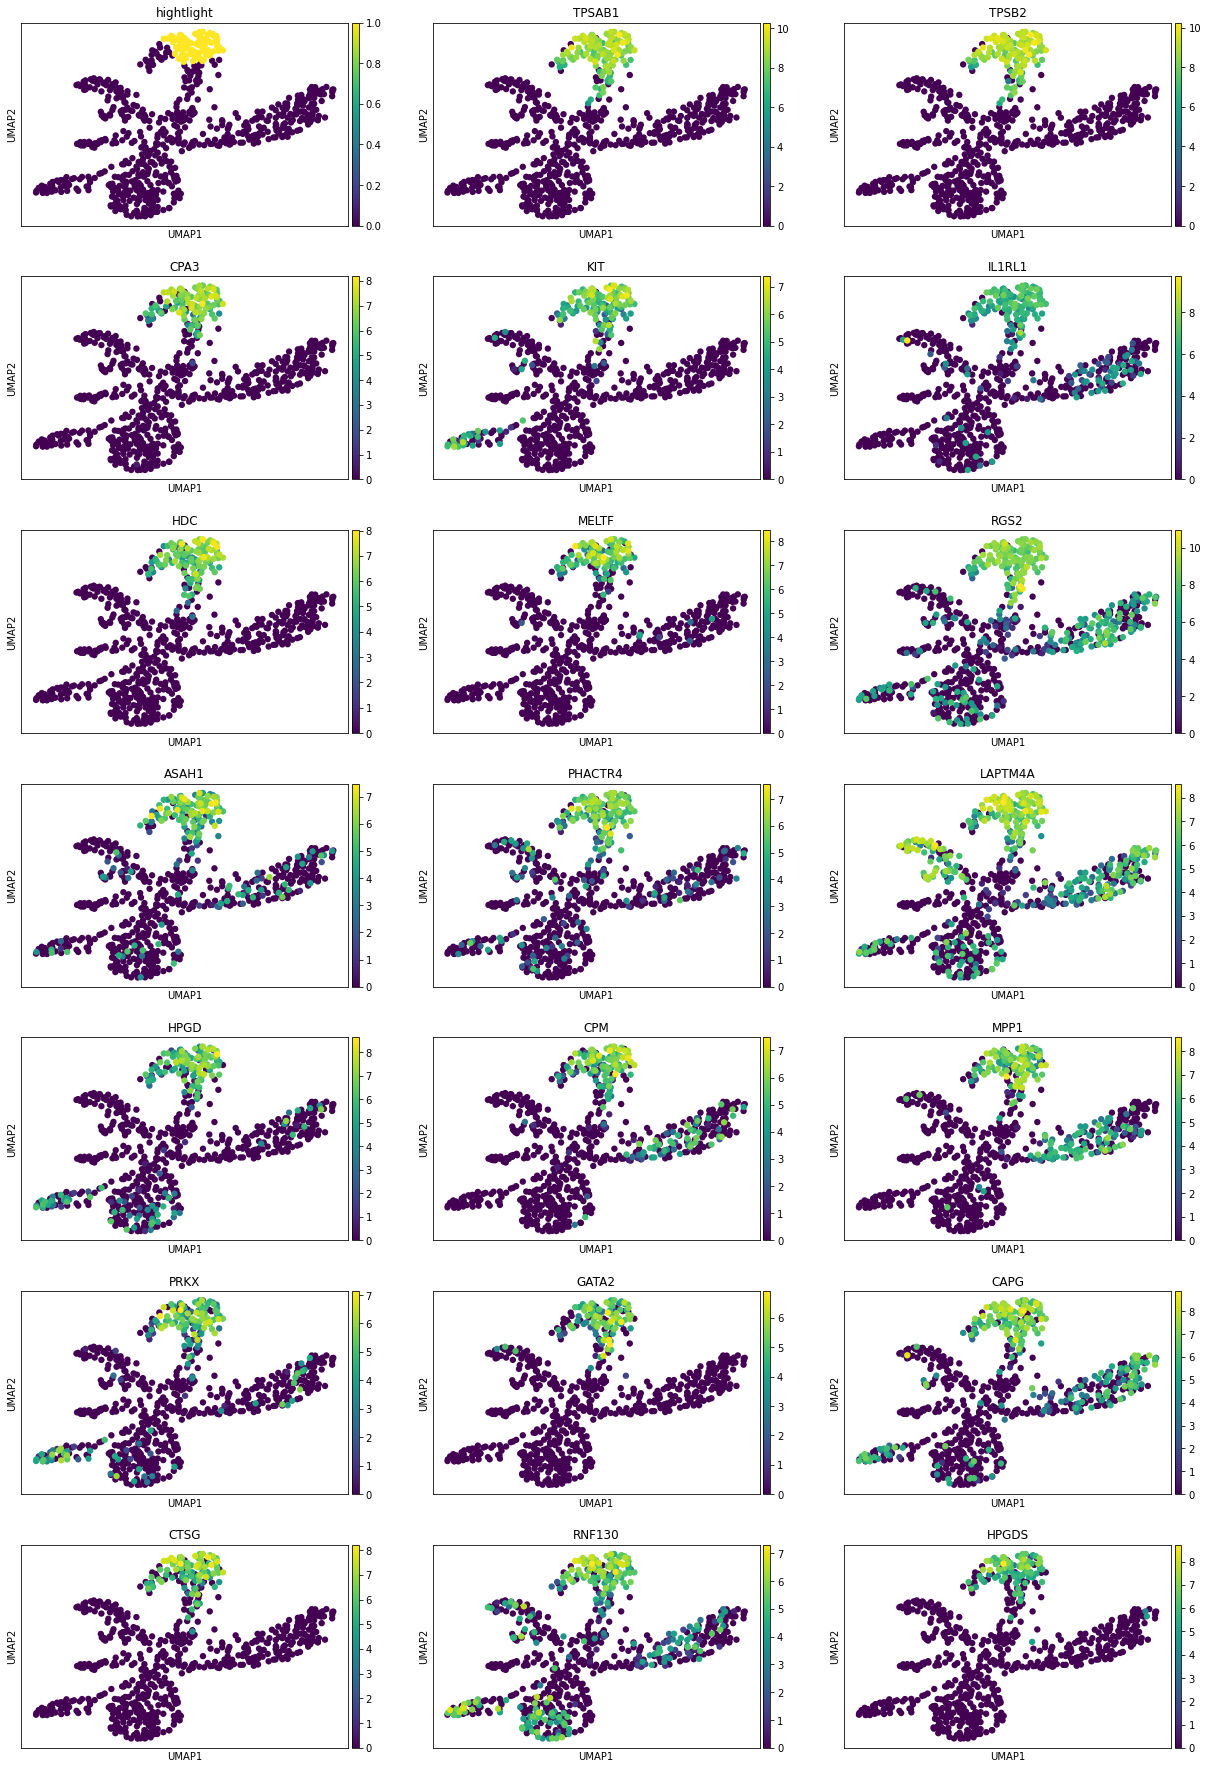

In [27]:
topgenes = list(DE["0"].T[:20].index)
organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == "0"
sc.pl.umap(
    organ_adata,
    color=["hightlight"] + topgenes,
    ncols=3,
)

You can do this for other clusters as well. Here I plot the top 5 genes for all other clusters

0


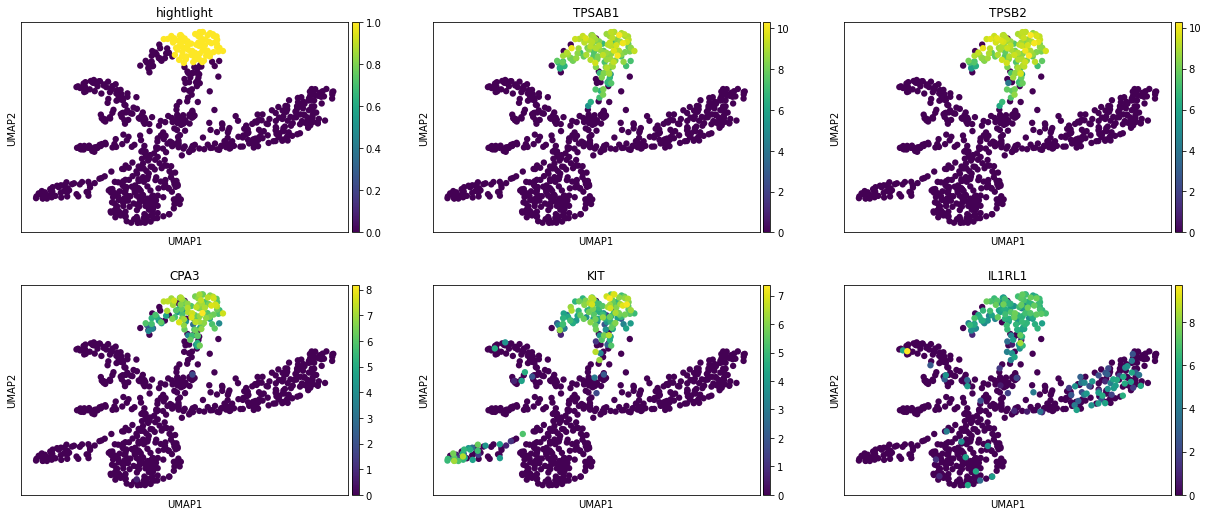

1


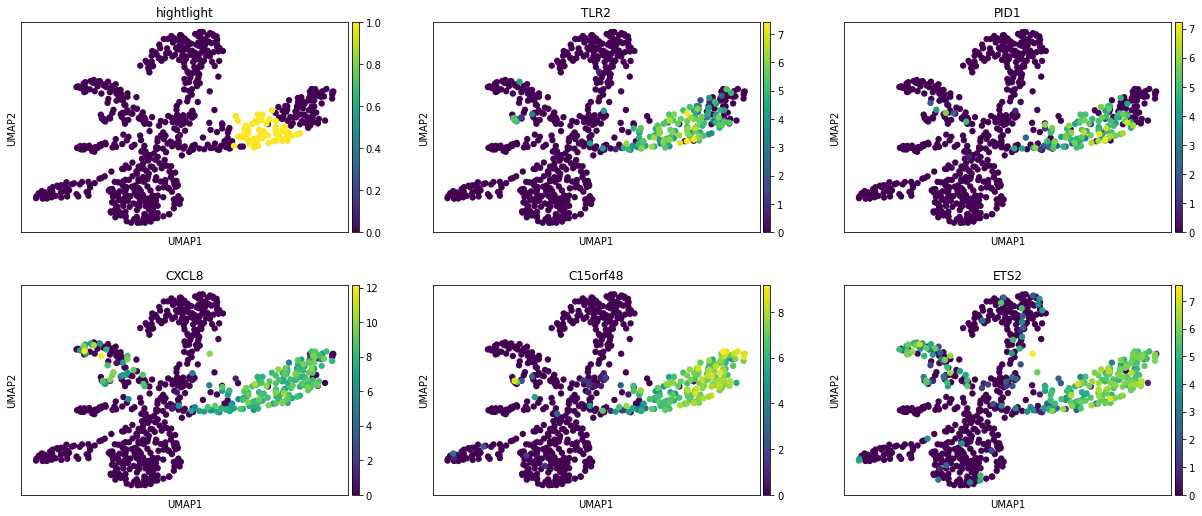

2


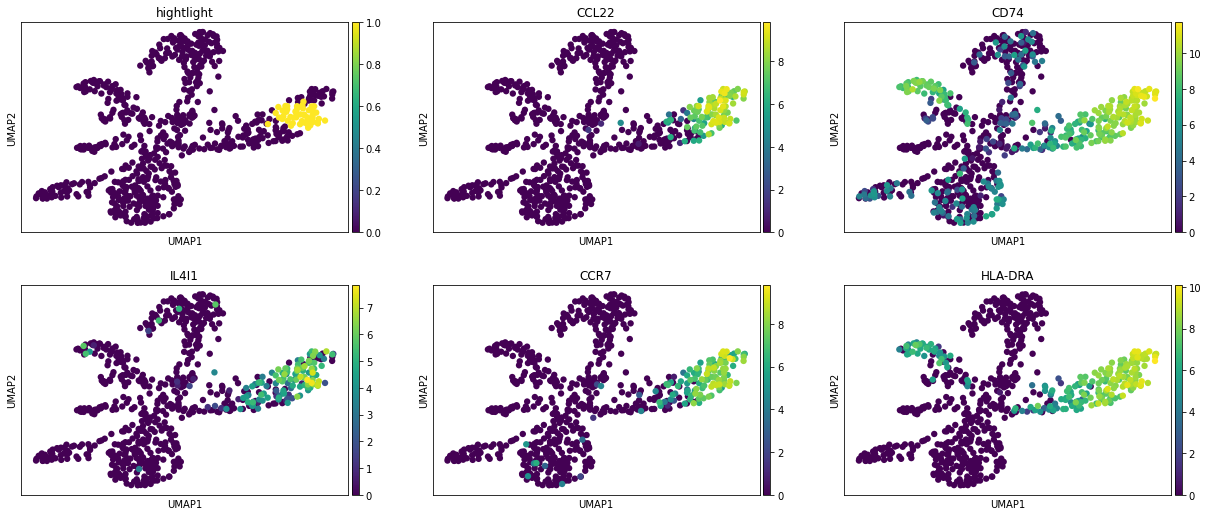

3


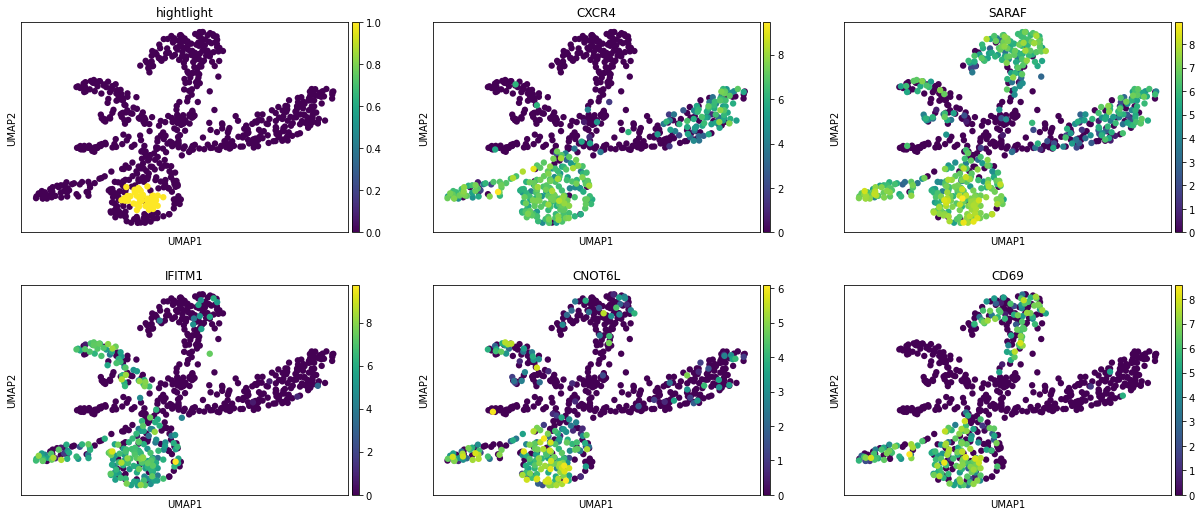

4


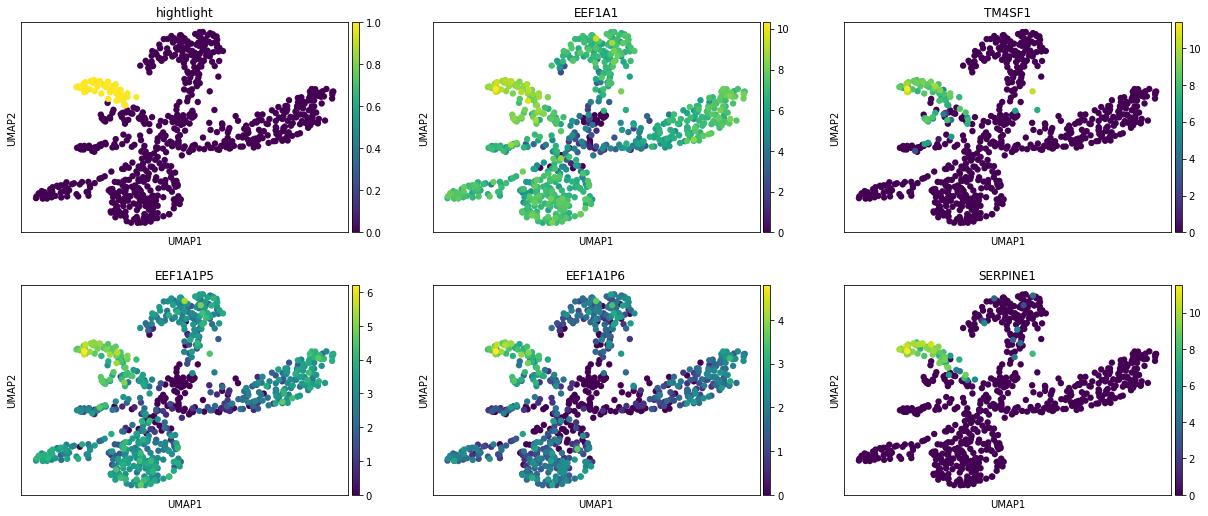

5


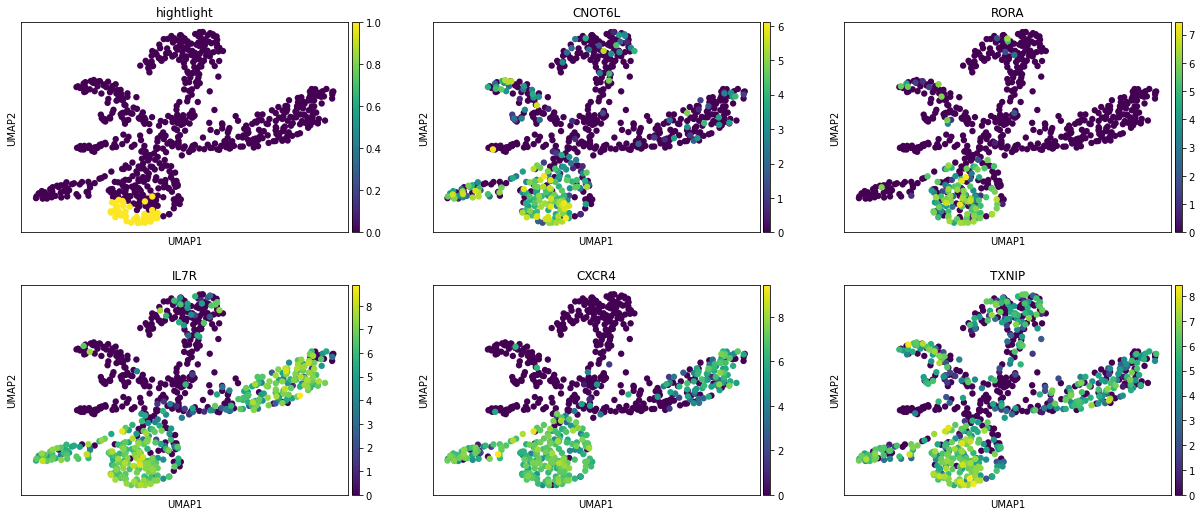

6


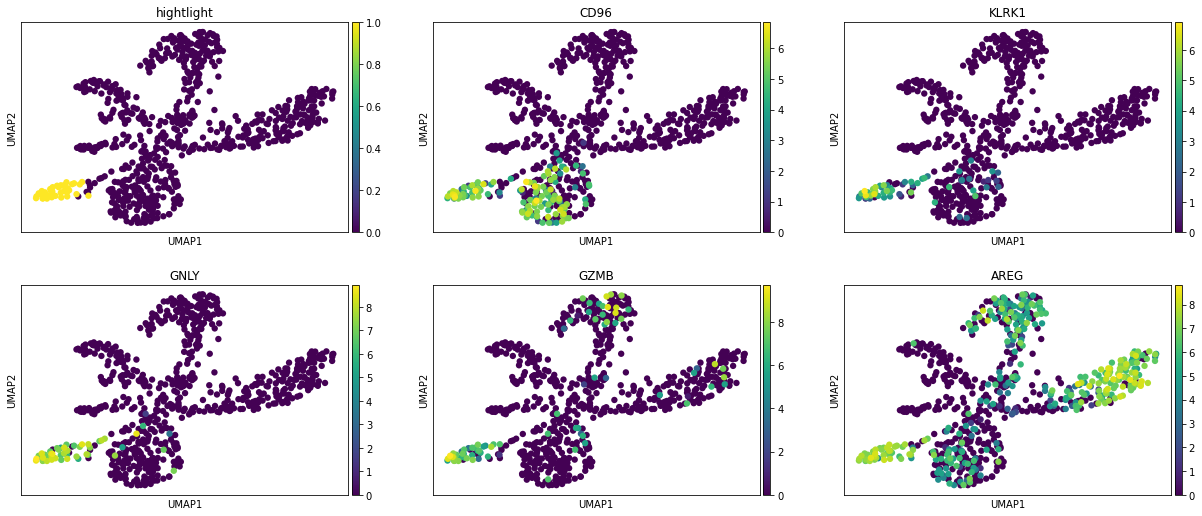

7


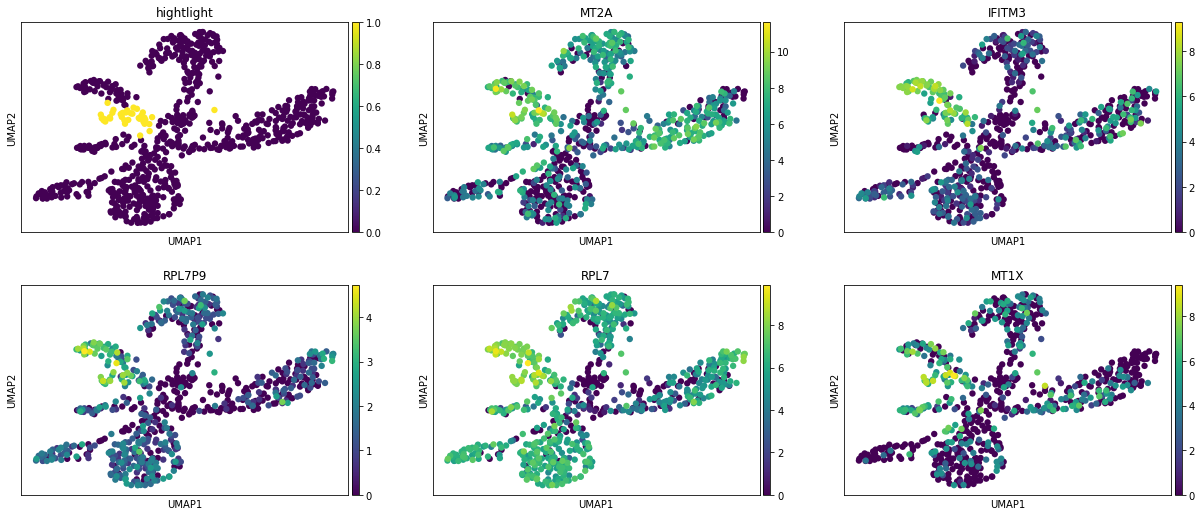

8


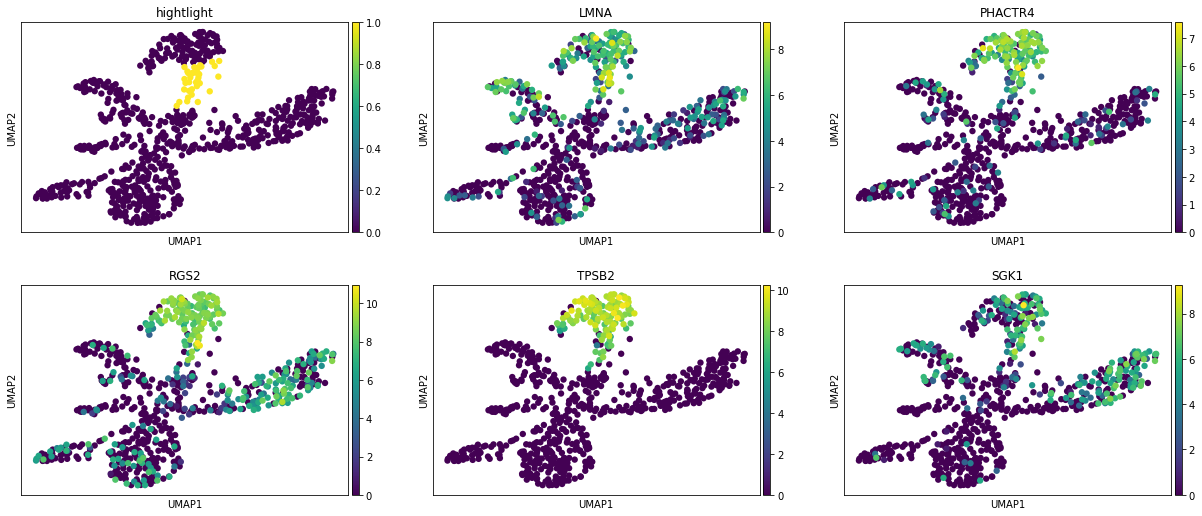

9


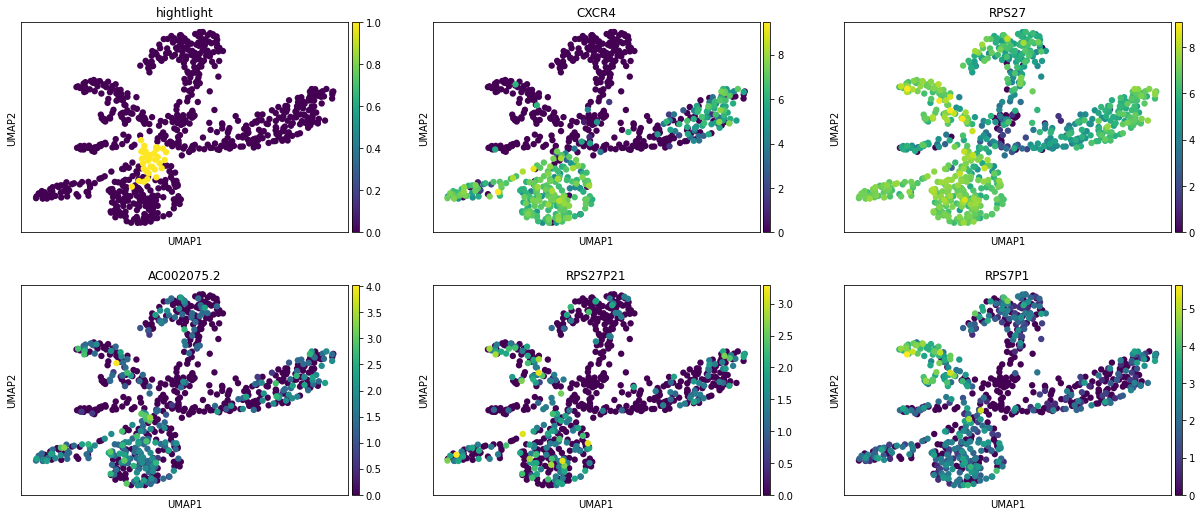

10


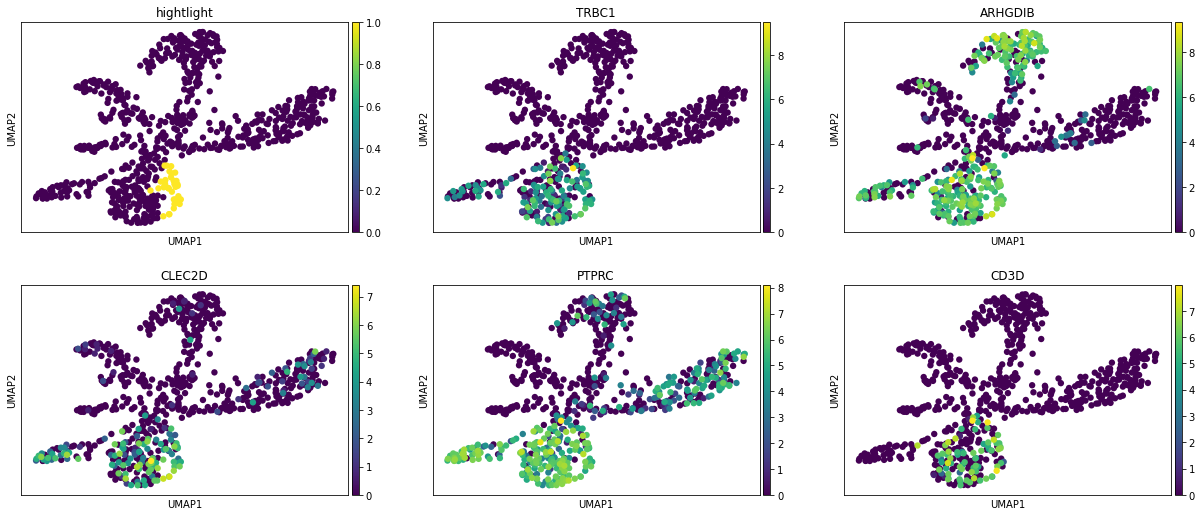

11


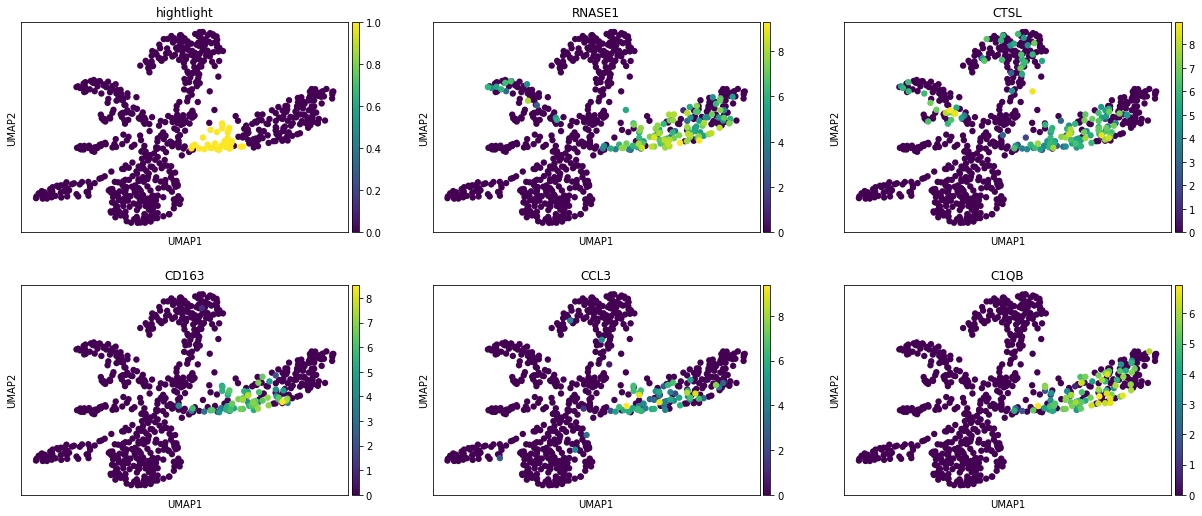

12


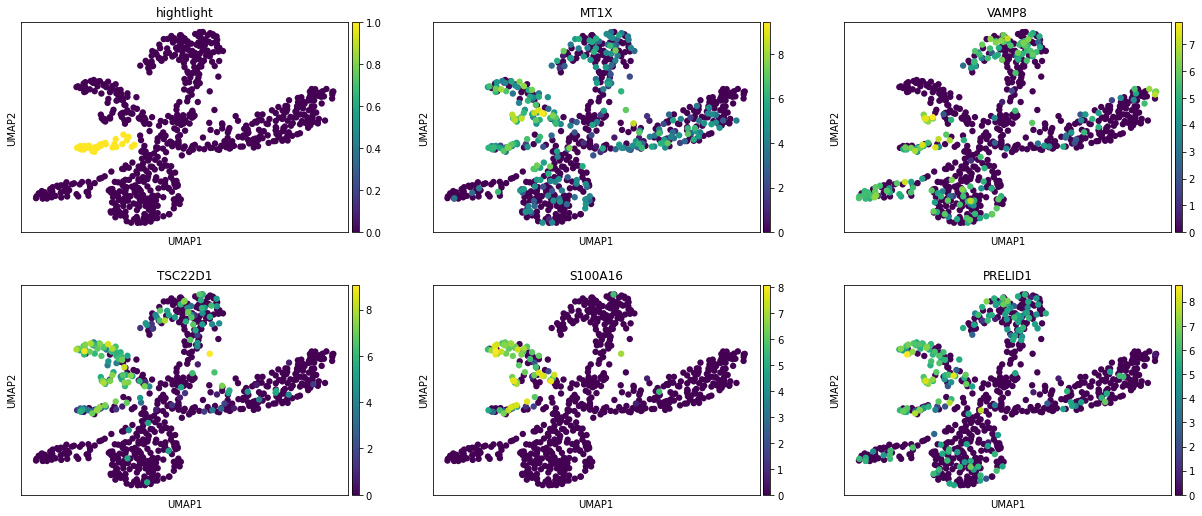

13


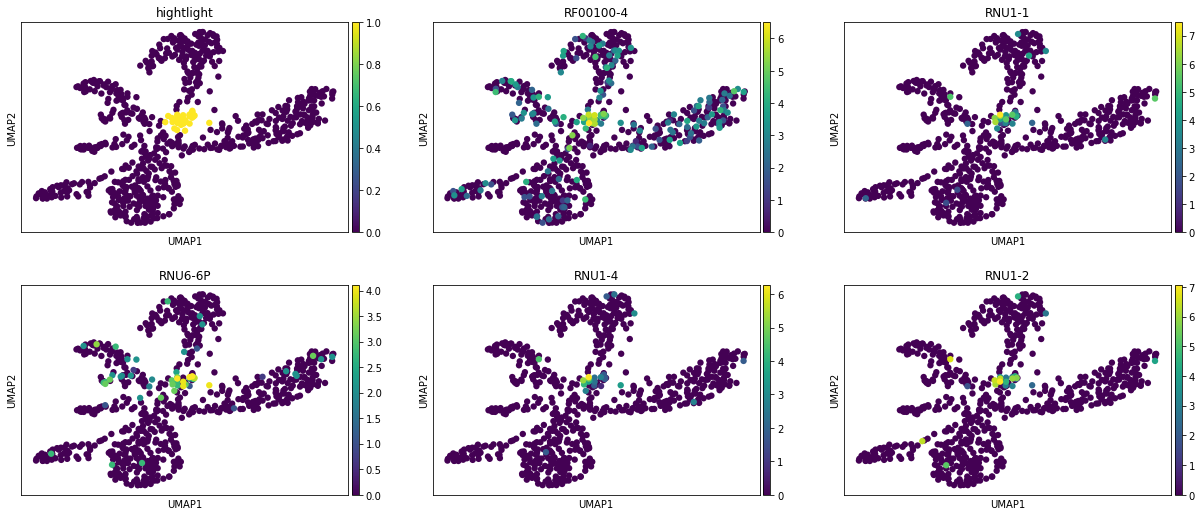

14


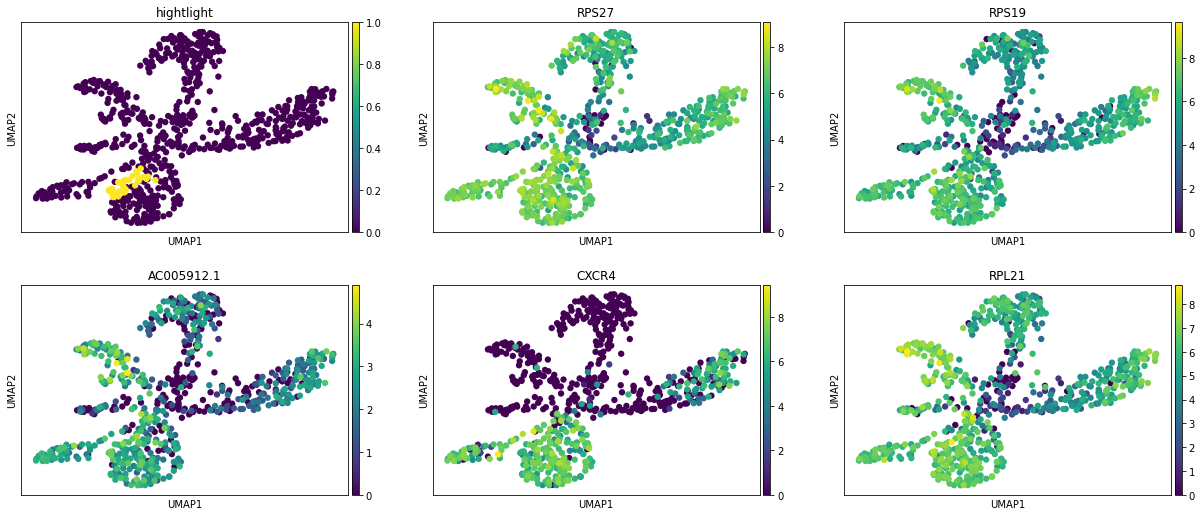

15


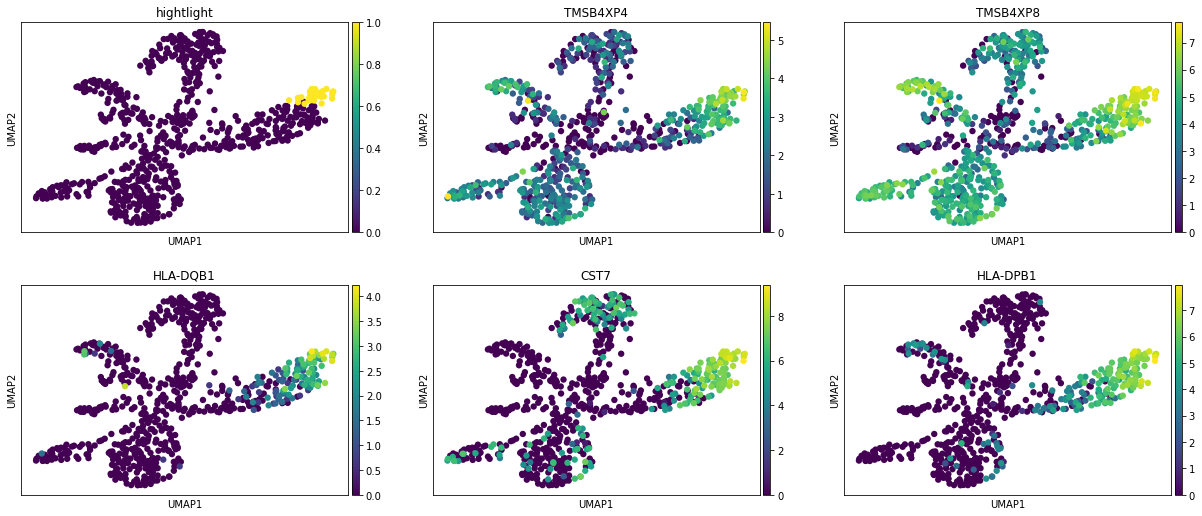

16


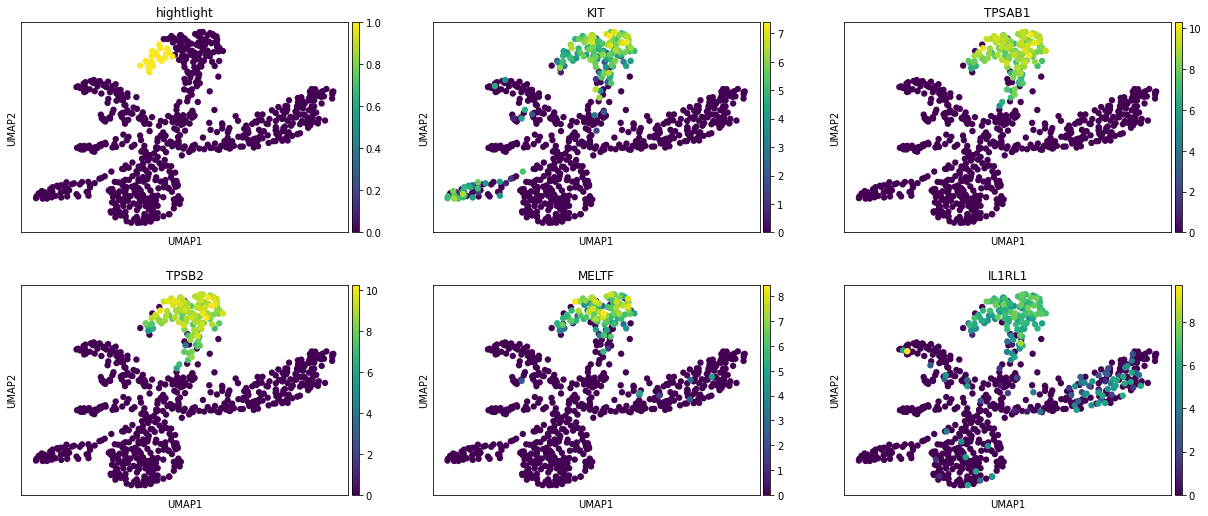

17


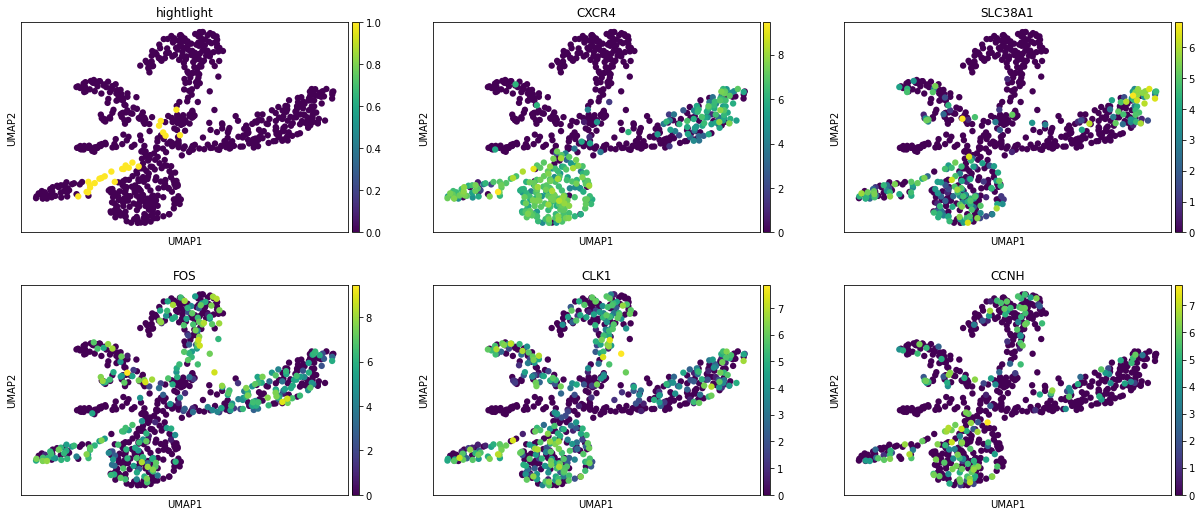

18


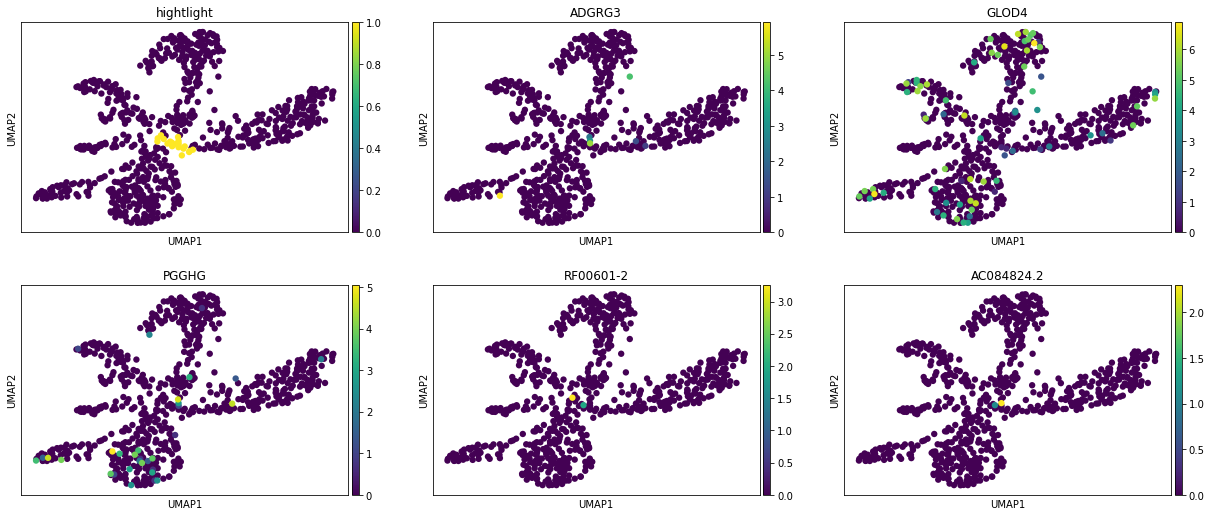

In [28]:
for x in DE.keys():
    print(x)
    topgenes = list(DE[x].T[:5].index)
    organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == x
    sc.pl.umap(
        organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

### The extended DE list can be queried by 

In [29]:
DE["0"].T

wilcoxon_score  log fold change  adjusted pvalue
TPSAB1       13.781761        12.615025     1.130673e-38
TPSB2        13.770391        12.859038     1.130673e-38
CPA3         13.600959        10.616597     7.755528e-38
KIT          13.498078         8.155722     2.362276e-37
IL1RL1       13.249059         8.518619     5.379497e-36
...                ...              ...              ...
PDE4B        -5.730222        -4.101249     2.838756e-06
ISG20        -6.422652        -6.687520     5.513223e-08
CYTIP        -6.433466       -33.438503     5.170859e-08
PRDM1        -6.744048       -31.998451     6.975364e-09
CXCR4        -6.921523       -33.986588     2.156063e-09

[58870 rows x 3 columns]

# read in cell ontology 

In [30]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [31]:
celltype_dict["T cell"]

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [32]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-negative, CD8-negative, alpha-beta intraepithelial T cell',
 'CD4-positive type I NK T cell secreting interleukin-4',
 'mature CD4 single-positive thymocyte',
 'CD4-positive, alpha-beta memory T cell',
 'CD24-positive, CD4 single-positive thymocyte',
 'CD4-positive, alpha-beta thymocyte',
 'CD4-positive, alpha-beta T cell',
 'central memory CD4-positive, alpha-beta T cell',
 'CD4-positive, CXCR3-negative, CCR6-negative, alpha-beta T cell',
 'activated CD4-positive type I NK T cell',
 'CD4-negative, CD8-negative type I NK T cell',
 'CD4-positive, CD8-intermediate double-positive thymocyte',
 'activated CD4-positive, alpha-beta T cell, human',
 'CD4-positive helper T cell',
 'CD4-negative CD8-negative gamma-delta intraepithelial T cell',
 'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
 'effector CD4-positive, alpha-beta T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interfer

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [33]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()
cluster_mapping = {"0": "T cell"}
cluster_markers = {"0": ["CXCR4", "CD3D", "IL7R", "IL32"]}

This cell will automatically replace the leiden cluster names with cell type annotations

In [34]:
for l in cluster_mapping.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, cluster_mapping[l], inplace=True)
    display(DE[l][cluster_markers[l]])

CXCR4       CD3D      IL7R       IL32
wilcoxon_score  -6.921523e+00  -1.663828 -5.093531  -3.837896
log fold change -3.398659e+01 -29.668581 -3.358970 -31.534119
adjusted pvalue  2.156063e-09   1.000000  0.000077   0.014909

# Visualize the results of the manual annotation

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



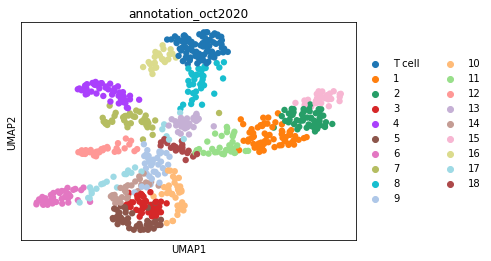

In [35]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# create celltype subcluster
This is just an example once the celltype annotations are done, how to subcluster cells in a celltype

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



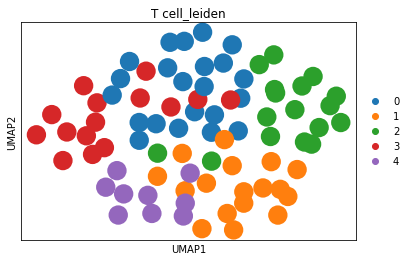

In [36]:
celltype = "T cell"
sub_organ_adata = organ_adata[organ_adata.obs["annotation_oct2020"] == celltype]
sc.pp.neighbors(sub_organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(
    sub_organ_adata,
)
sc.tl.leiden(sub_organ_adata, resolution=1, key_added="%s_leiden" % celltype)
sc.pl.umap(
    sub_organ_adata,
    color=["%s_leiden" % celltype],
    ncols=3,
)

In [37]:
sc.tl.rank_genes_groups(
    sub_organ_adata, groupby="%s_leiden" % celltype, method="wilcoxon"
)
sub_DE = FormatDE(sub_organ_adata.uns["rank_genes_groups"])

0


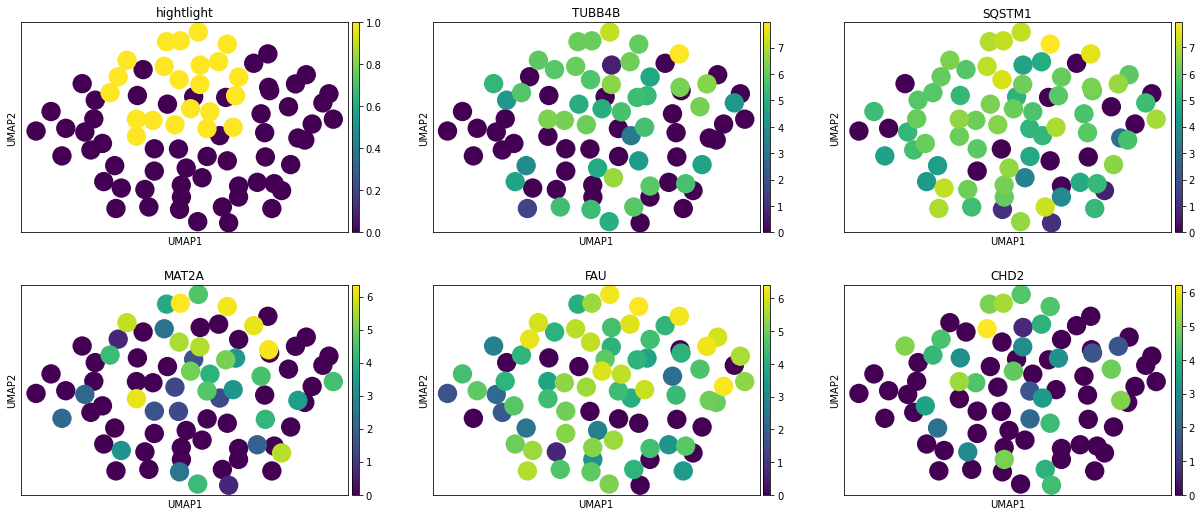

1


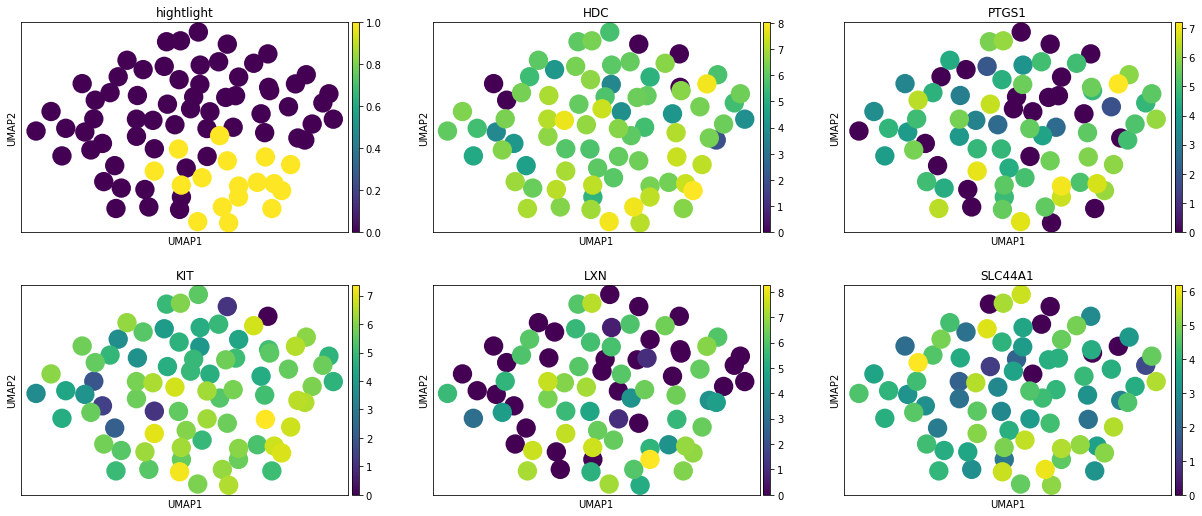

2


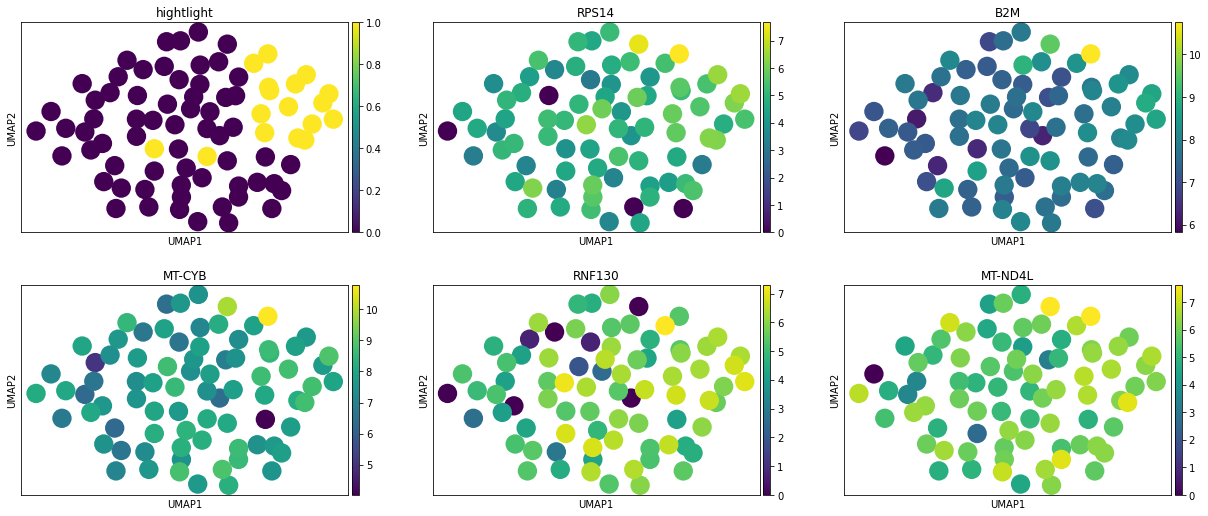

3


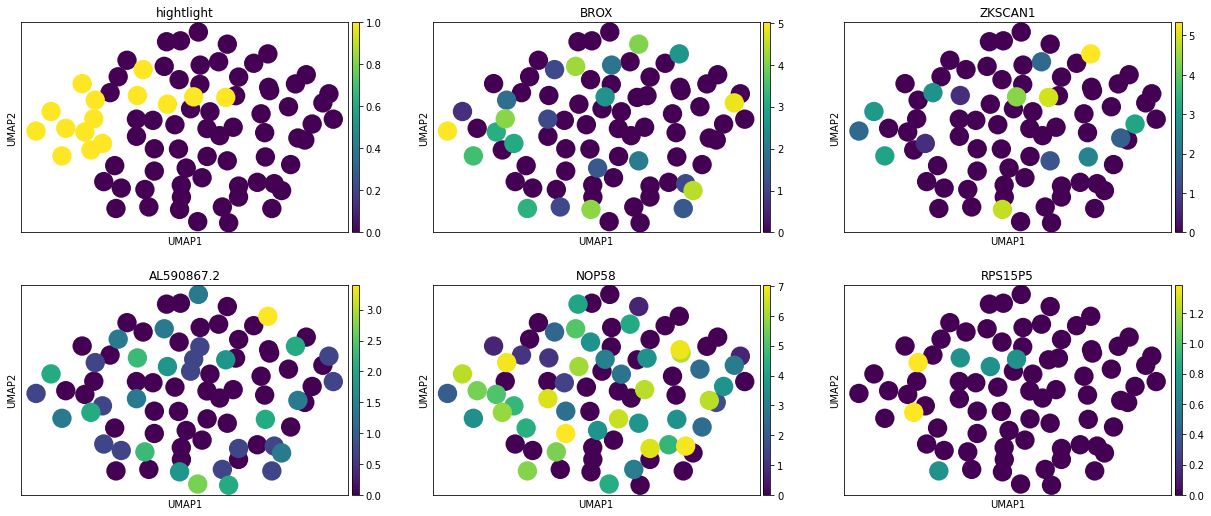

4


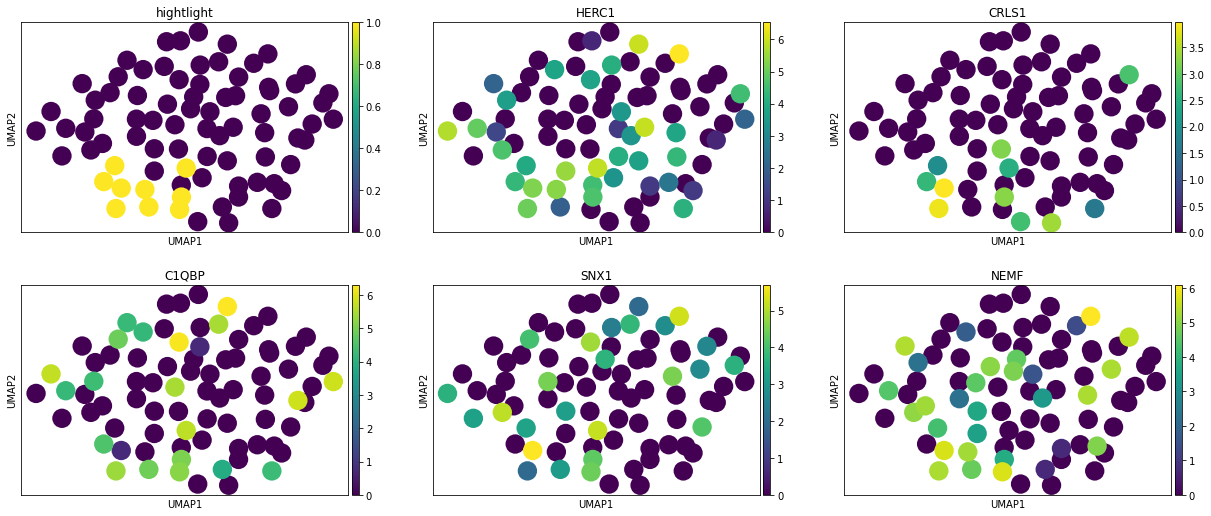

In [38]:
for x in sub_DE.keys():
    print(x)
    topgenes = list(sub_DE[x].T[:5].index)
    sub_organ_adata.obs["hightlight"] = sub_organ_adata.obs["%s_leiden" % celltype] == x
    sc.pl.umap(
        sub_organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

# manually create mapping between cell type and compartment (this is just an example)

In [39]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()
compartment_mapping = {"T cell": "Immune"}

This cell will automatically replace the leiden cluster names with cell type annotations

In [40]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

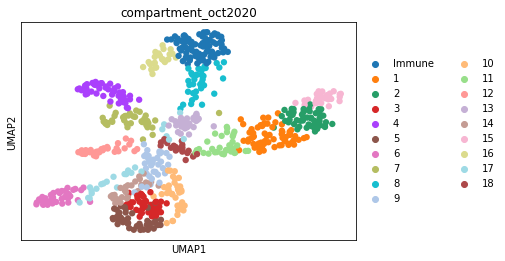

In [41]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [42]:
organ_adata.write_h5ad(
    data_path + "decontX/organ_data/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)